# Analysis of the Combined data for 7pad Scanning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from single_pad_analysis.analysis_functions import *
from single_pad_analysis.HexDetector import HexDetector

In [2]:
run_number = 325
basedir_path = 'scan_pad_dfs/'
get_pad_csv_path = lambda pool_num, mm_channel: f'{basedir_path}Run{run_number}-Pool{pool_num}-{mm_channel}.csv'

pad_centers_df = pd.read_csv(f'{basedir_path}scan_pad_centers.csv')

In [3]:
class Pad:
    def __init__(self, pool_num, mm_channel, pad_index=0):
        self.pool_num = pool_num
        self.mm_channel = mm_channel
        self.pad_index = pad_index
        self.x_center = None
        self.y_center = None
        self.df = None

    def __repr__(self):
        return f"Pad(pool_num={self.pool_num}, mm_channel={self.mm_channel}, pad_index={self.pad_index}, x_center={self.x_center}, y_center={self.y_center})\n{self.df}"

In [4]:
pads = [  # Need to be careful about the pad index, has to match the HexDetector indexing!
    Pad(4, 'C2', 1),
    Pad(4, 'C4', 0),
]

In [5]:
# Update pads with pad center information
for pad in pads:
    pad_center_row = pad_centers_df[(pad_centers_df['run_number'] == run_number) & (pad_centers_df['pool_number'] == pad.pool_num) & (pad_centers_df['channel_number'] == pad.mm_channel)]
    if pad_center_row.empty:
        print(f"Pad center not found for run {run_number}, pool {pad['pool_num']}, channel {pad['mm_channel']}")
        continue
    elif len(pad_center_row) > 1:
        print(f"Multiple pad centers found for run {run_number}, pool {pad['pool_num']}, channel {pad['mm_channel']}")
        continue
    pad_center_row = pad_center_row.iloc[0]
    x_center = Measure(pad_center_row['x_center'], pad_center_row['x_center_err'])
    y_center = Measure(pad_center_row['y_center'], pad_center_row['y_center_err'])
    pad.x_center = x_center
    pad.y_center = y_center

In [6]:
# Load dataframes for each pad
for pad in pads:
    pad.df = pd.read_csv(get_pad_csv_path(pad.pool_num, pad.mm_channel))

In [7]:
# Get combined dataframe, concatenating on SRSNo
df_combined = None
for pad in pads:
    cols_rename = {x: f'{x}_{pad.pad_index}' for x in pad.df.columns if x != 'SRSNo'}
    if df_combined is None:
        df_combined = pad.df.rename(columns=cols_rename)
    else:
        df_combined = df_combined.merge(pad.df.rename(columns=cols_rename), on='SRSNo', how='outer')

# Get nan-ignored average of hitX and hitY
df_combined['hitX'] = df_combined[[f'hitX_{pad.pad_index}' for pad in pads]].mean(axis=1)
df_combined['hitY'] = df_combined[[f'hitY_{pad.pad_index}' for pad in pads]].mean(axis=1)

In [8]:
# Need to be careful about the pad index, has to match the pads indexing!
detector = HexDetector(4.3, 29.9, 26.8, np.deg2rad(5.5))
detector.add_pad(0, 1, 1)

In [9]:
# Align hex detector to pad centers
def chi_square(params, pads, detector):
    x_center, y_center, angle = params
    detector.set_rotation(np.deg2rad(angle))
    detector.set_center(x_center, y_center)

    chi2_dx, chi2_dy = 0, 0
    for pad in pads:
        det_x, det_y = detector.get_pad_center(pad.pad_index)
        chi2_dx += ((pad.x_center.val - det_x) / pad.x_center.err)**2
        chi2_dy += ((pad.y_center.val - det_y) / pad.y_center.err)**2

    return np.sum(chi2_dx + chi2_dy)


def fit_hex_detector_to_pad_centers(pads, detector, x0=0, y0=0, angle0=0):
    initial_guess = [x0, y0, angle0]
    bounds = ((0, 100), (0, 100), (-20, 20))  # No bounds on x and y, angle between -180 and 180 degrees
    result = minimize(chi_square, initial_guess, args=(pads, detector), bounds=bounds)
    return result

# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads, detector, x0=29.9, y0=26.8, angle0=5.5)
print(fit_result)
print(fit_result.x)
detector.set_center(fit_result.x[0], fit_result.x[1])
detector.set_rotation(np.deg2rad(fit_result.x[2]))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.475013429443713
        x: [ 2.991e+01  2.670e+01  5.822e+00]
      nit: 13
      jac: [-8.974e-04  1.668e-03  7.923e-05]
     nfev: 64
     njev: 16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[29.91256105 26.70239789  5.82206693]


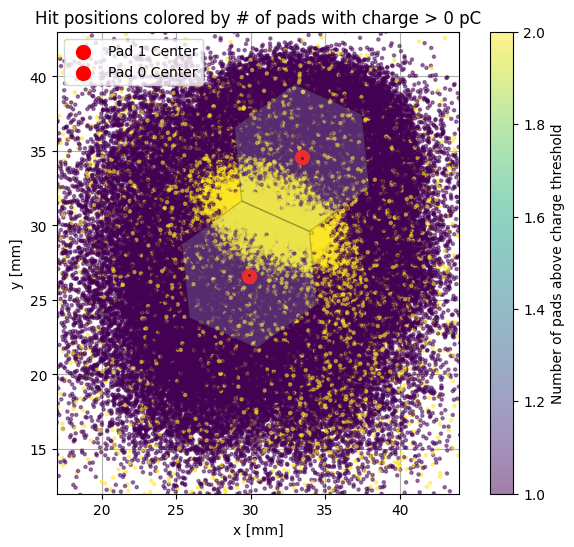

In [10]:
threshold = 0

# Replace NaNs with 0 (or any value below threshold)
totcharge_cols = [f'totcharge_{pad.pad_index}' for pad in pads]
charges = df_combined[totcharge_cols].fillna(0)

# Count how many values in each row are > threshold
charge_count = (charges > threshold).sum(axis=1)

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=charge_count, cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)

for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')

ax.grid(True)
ax.legend()
ax.set_aspect('equal')

detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)

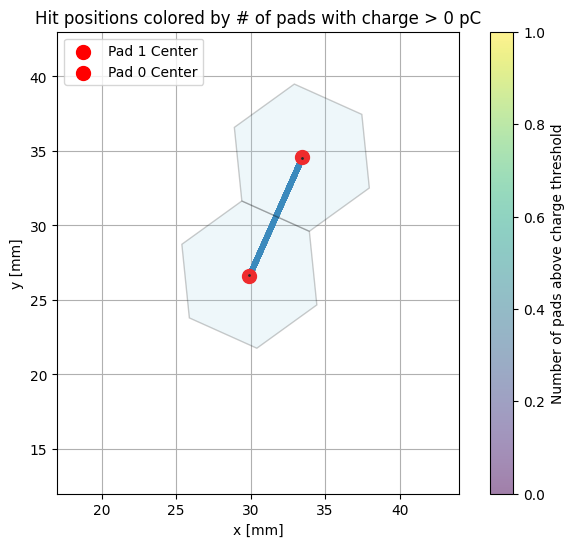

In [12]:
pad0_weight = df_combined[f'totcharge_0'].fillna(0)
pad1_weight = df_combined[f'totcharge_1'].fillna(0)
weight_sum = pad0_weight + pad1_weight

x_hits = (pads[0].x_center.val * pad0_weight + pads[1].x_center.val * pad1_weight) / weight_sum
y_hits = (pads[0].y_center.val * pad0_weight + pads[1].y_center.val * pad1_weight) / weight_sum

# Now plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x_hits, y_hits, cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='Number of pads above charge threshold')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Hit positions colored by # of pads with charge > {threshold} pC')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')
ax.grid(True)
ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)



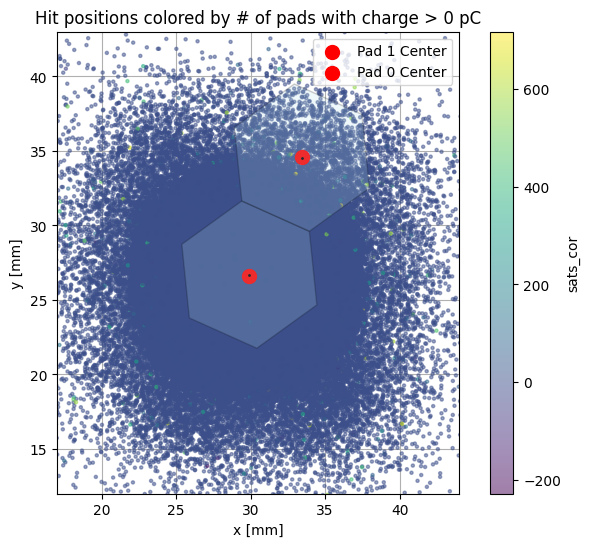

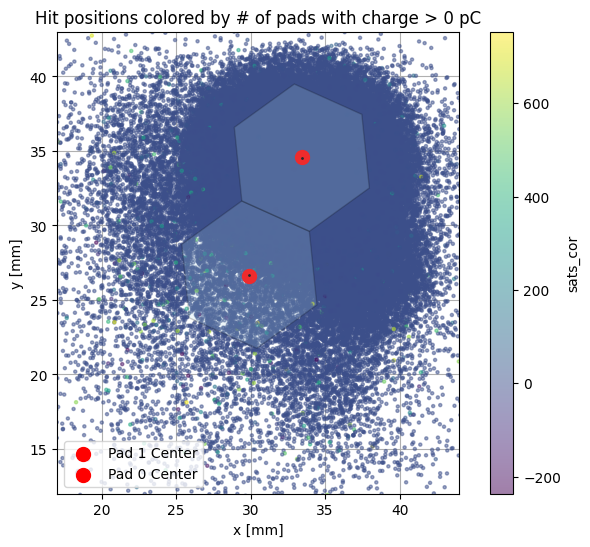

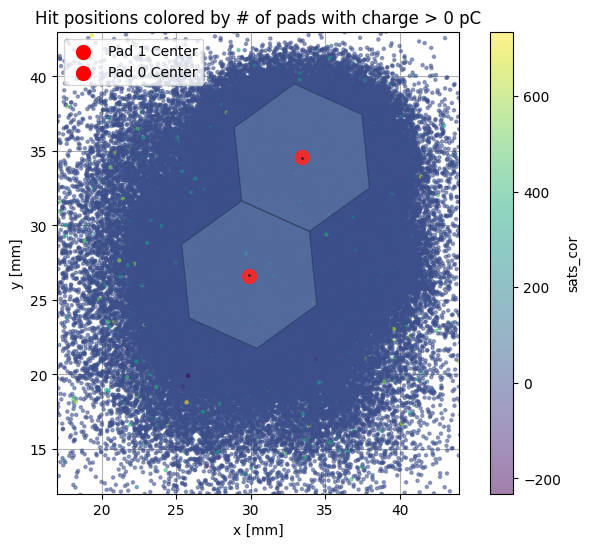

In [14]:
pad0_time_diff = df_combined[f'time_diff_0'].fillna(0)
pad1_time_diff = df_combined[f'time_diff_1'].fillna(0)
pad0_time_diff_cor = df_combined[f'time_diff_cor_0'].fillna(0)
pad1_time_diff_cor = df_combined[f'time_diff_cor_1'].fillna(0)
pad0_weight = df_combined[f'charge_time_res_0'].fillna(0)
pad1_weight = df_combined[f'charge_time_res_1'].fillna(0)
weight_sum = pad0_weight + pad1_weight

sats_raw = (pad0_time_diff * pad0_weight + pad1_time_diff * pad1_weight) / weight_sum
sats_cor = (pad0_time_diff_cor * pad0_weight + pad1_time_diff_cor * pad1_weight) / weight_sum


# Plot 2D scatter plot of histX_0 and histY_0 with color determined by time_diff_0
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=df_combined[f'time_diff_cor_0'], cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='sats_cor')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Time Diff Cor 0')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')
ax.grid(True)
ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)

# Plot 2D scatter plot of histX_0 and histY_0 with color determined by sats_cor
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=df_combined[f'time_diff_cor_1'], cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='sats_cor')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Time Diff Cor 1')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')
ax.grid(True)
ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)

# Plot 2D scatter plot of histX_0 and histY_0 with color determined by sats_cor
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_combined[f'hitX'], df_combined[f'hitY'], c=sats_cor, cmap='viridis', s=5, zorder=2, alpha=0.5)
fig.colorbar(scatter, label='sats_cor')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_title(f'Time Diff Average')
ax.set_xlim(17, 44)
ax.set_ylim(12, 43)
for pad in pads:
    ax.scatter(pad.x_center.val, pad.y_center.val, s=100, color='red', zorder=3, label=f'Pad {pad.pad_index} Center')
ax.grid(True)
ax.legend()
ax.set_aspect('equal')
detector.plot_detector(global_coords=True, ax_in=ax, pad_alpha=0.2)


In [ ]:
xs = np.linspace(20, 40, 100)
ys = np.linspace(15, 42, 100)